In [1]:
import netCDF4 as nc
#ds_out=xr.Dataset({'total_column_water_vapour':tpw_xr,'total_precipitation':tp_xr,'u_component_of_wind':u_wind_xr,'v_component_of_wind':v_wind_xr,'geopotential':geopotential_xr,'mean_sea_level_pressure':mean_sea_level_pressure_xr,'temperature_2m':temp_2m_year_xr,'surface_pressure':surface_pressure_year_xr})
import glob
fs=glob.glob('weath*.nc')
fs=sorted(fs)[:-1]
print(fs)
#!pwd
import numpy as np


icount=0

for f in fs:
    with nc.Dataset(f) as fh:
        u=fh.variables['u_component_of_wind'][:]
        v=fh.variables['v_component_of_wind'][:]
        tp=fh.variables['total_precipitation'][:]
        tpw=fh.variables['total_column_water_vapour'][:]
        geopotential=fh.variables['geopotential'][:]
        mslp=fh.variables['mean_sea_level_pressure'][:]
        temp_2m=fh.variables['temperature_2m'][:]
        sp=fh.variables['surface_pressure'][:]
        lon=fh.variables['lon'][:]
        lat=fh.variables['lat'][:]
        #tp_mean+=tp.mean(axis=0)
        if icount==0:
            u_all=u
            v_all=v
            tp_all=tp   
            tpw_all=tpw
            geopotential_all=geopotential
            mslp_all=mslp
            temp_2m_all=temp_2m
            sp_all=sp
        else:
            u_all=np.concatenate((u_all,u),axis=0)
            v_all=np.concatenate((v_all,v),axis=0)
            tp_all=np.concatenate((tp_all,tp),axis=0)
            tpw_all=np.concatenate((tpw_all,tpw),axis=0)
            geopotential_all=np.concatenate((geopotential_all,geopotential),axis=0)
            mslp_all=np.concatenate((mslp_all,mslp),axis=0)
            temp_2m_all=np.concatenate((temp_2m_all,temp_2m),axis=0)
            sp_all=np.concatenate((sp_all,sp),axis=0)
        icount+=1
        #break

#tp_mean/=icount

['weatherbench2_conus_subset_2001.nc', 'weatherbench2_conus_subset_2002.nc', 'weatherbench2_conus_subset_2003.nc', 'weatherbench2_conus_subset_2004.nc', 'weatherbench2_conus_subset_2005.nc', 'weatherbench2_conus_subset_2006.nc', 'weatherbench2_conus_subset_2007.nc', 'weatherbench2_conus_subset_2008.nc', 'weatherbench2_conus_subset_2009.nc', 'weatherbench2_conus_subset_2010.nc', 'weatherbench2_conus_subset_2011.nc', 'weatherbench2_conus_subset_2012.nc', 'weatherbench2_conus_subset_2013.nc', 'weatherbench2_conus_subset_2014.nc', 'weatherbench2_conus_subset_2015.nc', 'weatherbench2_conus_subset_2016.nc', 'weatherbench2_conus_subset_2017.nc', 'weatherbench2_conus_subset_2018.nc', 'weatherbench2_conus_subset_2019.nc', 'weatherbench2_conus_subset_2020.nc']


In [2]:
print(u_all.shape)
def rescale_fields(u):
    ndims=u.shape
    u_mean=u.mean(axis=0)
    u_std=u.std(axis=0)
    u=(u-u_mean)/u_std
    return u
u_all_rescaled=rescale_fields(u_all)
v_all_rescaled=rescale_fields(v_all)
tp_all_rescaled=rescale_fields(tp_all)
tpw_all_rescaled=rescale_fields(tpw_all)
geopotential_all_rescaled=rescale_fields(geopotential_all)
mslp_all_rescaled=rescale_fields(mslp_all)
temp_2m_all_rescaled=rescale_fields(temp_2m_all)
sp_all_rescaled=rescale_fields(sp_all)

ntrain=6800
nval=400


(7200, 5, 48, 48)


In [3]:
tp_all[tp_all<0]=0
x_train=np.concatenate([u_all_rescaled[:ntrain],v_all_rescaled[:ntrain],tpw_all_rescaled[:ntrain,np.newaxis,:,:],geopotential_all_rescaled[:ntrain],mslp_all_rescaled[:ntrain,np.newaxis,:,:],temp_2m_all_rescaled[:ntrain,np.newaxis,:,:],sp_all_rescaled[:ntrain,np.newaxis,:,:]],axis=1)
print(x_train.shape)
y_train=np.log10(1+tp_all[:ntrain,np.newaxis,:,:]/0.0001)

x_val=np.concatenate([u_all_rescaled[ntrain:ntrain+nval],v_all_rescaled[ntrain:ntrain+nval],tpw_all_rescaled[ntrain:ntrain+nval,np.newaxis,:,:],geopotential_all_rescaled[ntrain:ntrain+nval],mslp_all_rescaled[ntrain:ntrain+nval,np.newaxis,:,:],temp_2m_all_rescaled[ntrain:ntrain+nval,np.newaxis,:,:],sp_all_rescaled[ntrain:ntrain+nval,np.newaxis,:,:]],axis=1)
y_val=np.log10(1+tp_all[ntrain:ntrain+nval,np.newaxis,:,:]/0.0001)

(6800, 19, 48, 48)


In [140]:
from neuralop.models import TFNO
from neuralop.models import FNO
nfactors=3
operator = FNO(n_modes=(8, 8), hidden_channels=48,
                in_channels=19,
                out_channels=2+nfactors,
                factorization='tucker',
                implementation='factorized', n_layers=6,
                rank=0.05)

In [143]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import DataLoader, TensorDataset
#out=operator(torch.tensor(x_train[:1000,:,:,:]))
#print(out.shape)
loss=MSELoss()
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal
def NLLLoss(output, target):
    nb, nc, nx, ny = output.shape
    mean = output[:,0,:,:].reshape(nb, -1).abs()

    cov_diag = torch.exp(output[:,1,:,:]).reshape(nb,-1)+0.01
    factors = output[:,2:,:,:]
    nfact=factors.shape[1]
    factors_permuted = factors.permute(0, 2, 3, 1).reshape(nb, -1, nfact)
    dist = LowRankMultivariateNormal(mean, factors_permuted, cov_diag)
    return -dist.log_prob(target[:,0,:,:].reshape(nb,-1)).mean()
opt=Adam(operator.parameters(),lr=0.001)
x_train_t=torch.tensor(x_train[:,:,6:38,6:38]).float()
y_train_t=torch.tensor(y_train[:,:,6:38,6:38]).float()
x_val_t=torch.tensor(x_val[:,:,6:38,6:38]).float()
y_val_t=torch.tensor(y_val[:,:,6:38,6:38]).float()
train_data=TensorDataset(x_train_t,y_train_t)
val_data=TensorDataset(x_val_t,y_val_t)
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=True)


In [150]:
nepochs=6
for epoch in range(nepochs):
    operator.train()
    avg_loss=0
    for x,y in train_loader:
        opt.zero_grad()
        y_pred=operator(x)
        #l=loss(y_pred,y)
        l=NLLLoss(y_pred,y)
        l.backward()
        avg_loss+=l.item()
        opt.step()
    #operator.eval()
    #with torch.no_grad():
    #    for x,y in val_loader:
    #        y_pred=operator(x)
    #        l=loss(y_pred,y)
    #        print(l.item())
    print('epoch',epoch,avg_loss/len(train_loader))
    #break

epoch 0 -273.53660576332345
epoch 1 -281.1144174566851
epoch 2 -286.26817823239895
epoch 3 -292.41843496689773
epoch 4 -299.89465776183795
epoch 5 -305.2247684102663


[[1.         0.83169105]
 [0.83169105 1.        ]]
0.4536179 0.38471645


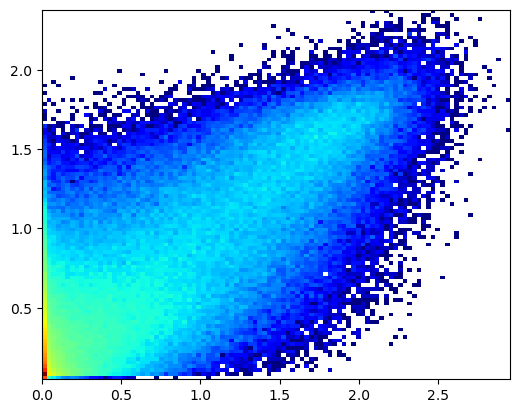

In [151]:
#operator.eval()
y_pred_all=operator(x_val_t)
y_pred=y_pred_all[:,0:1,:,:].abs()

print(np.corrcoef(y_pred.detach().numpy().flatten(),y_val_t.numpy().flatten()))
import matplotlib.pyplot as plt
import matplotlib
ax=plt.subplot(111)
h2d=plt.hist2d(y_val_t.numpy().flatten(),y_pred.detach().numpy().flatten(),bins=100,norm=matplotlib.colors.LogNorm(),cmap='jet')
ax.set_aspect('equal')
print(np.mean(y_pred.detach().numpy().flatten()),np.mean(y_val_t.numpy().flatten()))

In [139]:
# print number of parameters in the model
print(sum(p.numel() for p in operator.parameters()))

42341


(400, 1, 32, 32)


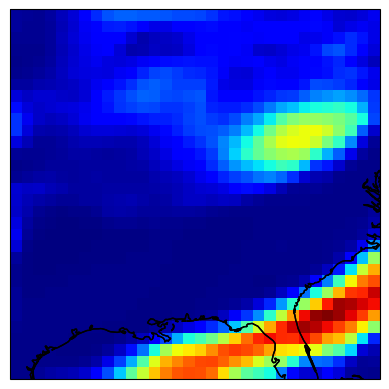

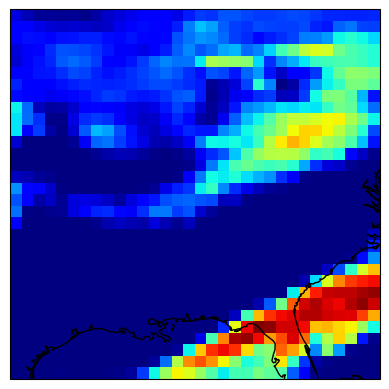

In [152]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import cartopy.crs as ccrs
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
y_pred_np=y_pred.detach().numpy()
print(y_pred_np.shape)
ax=plt.subplot(111,projection=ccrs.PlateCarree())
plt.pcolormesh(lon[6:38],lat[6:38],y_pred_np[100,0,:,:].T,cmap='jet')
ax.coastlines()
plt.figure()
ax=plt.subplot(111,projection=ccrs.PlateCarree())
plt.pcolormesh(lon[6:38],lat[6:38],y_val_t[100,0,:,:].numpy().T,cmap='jet')
ax.coastlines()

[[1.         0.07557539]
 [0.07557539 1.        ]]
-0.023585655 0.38471645


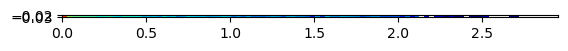

In [142]:
#save the full model

torch.save(operator,'fourier_operator_model_12_full.pt')

operator_loaded=torch.load('fourier_operator_model_12_full.pt')
y_pred_all=operator_loaded(x_val_t)
y_pred=y_pred_all[:,0:1,:,:]

print(np.corrcoef(y_pred.detach().numpy().flatten(),y_val_t.numpy().flatten()))
import matplotlib.pyplot as plt
import matplotlib
ax=plt.subplot(111)
h2d=plt.hist2d(y_val_t.numpy().flatten(),y_pred.detach().numpy().flatten(),bins=100,norm=matplotlib.colors.LogNorm(),cmap='jet')
ax.set_aspect('equal')
print(np.mean(y_pred.detach().numpy().flatten()),np.mean(y_val_t.numpy().flatten()))

In [ ]:
import torch
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal

# Define the mean (4,4) array
mean = torch.randn(100,4, 4)

# Define the low-rank factors (2,4,4)
factor = torch.randn(100,2, 4, 4)

# Permute the dimensions to get (4,4,2)
permuted_factor = factor.permute(0,2, 3, 1)

# Define the diagonal covariance matrix (4,4)
cov_diag = torch.randn(100,4, 4).abs()+0.01  # Ensure non-negative values

# Create the LowRankMultivariateNormal distribution
dist = LowRankMultivariateNormal(mean, permuted_factor, cov_diag)

# Define a sample vector to calculate the likelihood for
sample_vector = torch.randn(100,4, 4)

# Calculate the log likelihood of the sample vector
log_likelihood = dist.log_prob(sample_vector).mean()

# Calculate the negative log likelihood
negative_log_likelihood = -log_likelihood

print("Log likelihood:", log_likelihood.item())
print("Negative log likelihood:", negative_log_likelihood.item())

In [101]:
np.zeros(2)
np.array([[1],[2]]).shape
import torch
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal

# Define the mean (4,4) array
mean = torch.randn(10,4, 4)

# Define the low-rank factors (2,4,4)
factor = torch.randn(10,2,4,4)
factor_permuted=factor.permute(0,2,3,1)

# Define the diagonal covariance matrix (4,4)
cov_diag = torch.randn(10,4, 4).abs()  # Ensure non-negative values

# Create the LowRankMultivariateNormal distribution
dist = LowRankMultivariateNormal(mean, factor_permuted, cov_diag)

# Sample from the distribution
sample = dist.sample()
log_likelihood = dist.log_prob(sample)

In [98]:
a=torch.randn(1,4,4)
a_rolled=torch.roll(a,shifts=-1,dims=0)
print(a_rolled.shape)
a_permuted=a.permute(1,2,0)
print(a_permuted.shape)

torch.Size([1, 4, 4])
torch.Size([4, 4, 1])


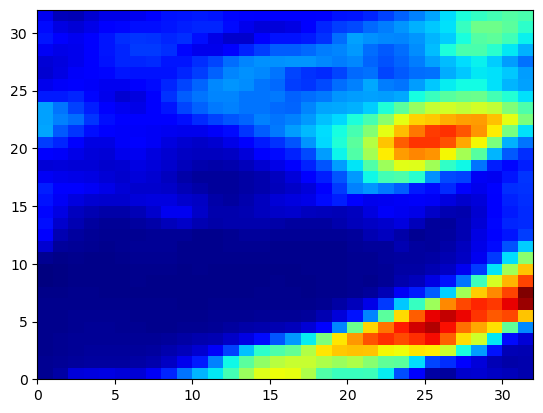

In [91]:

y_pred_fine=operator.forward(torch.tensor(x_val[:,:,6:38,6:38]).float())
plt.pcolormesh(y_pred_fine[100,0,:,:].detach().numpy().T,cmap='jet')